# imports

In [1]:
import pickle
from srgnn_pl import SRGNN_model, SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import pandas as pd
import yaml
from math import ceil

In [4]:
from sklearn.mixture import GaussianMixture

# global vars

In [5]:
dfs=[]
for k in tqdm(range(33003945//int(1e6))):
    df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                     nrows=int(1e6), skiprows=k*int(1e6), 
                     names=['session_id','timestamp','item_id','category'])
    df=df[['item_id', 'category']].drop_duplicates()
    dfs.append(df)
items_df=pd.concat(dfs).drop_duplicates()
del dfs

100%|██████████| 33/33 [02:24<00:00,  4.37s/it]


number differs as data for paper was preprocessed to use items with >=5 occurances

In [6]:
items_df=items_df.merge(pd.DataFrame(pickle.load(open('../datasets/yoochoose_itemdict_custom_augmented.txt', 'rb')), index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
             on='item_id')
items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]

In [7]:
with open('../datasets/yoochoose_custom/yoo_df.txt', 'rb') as f:
    yoo_df=pickle.load(f)
    freq_df=pd.DataFrame(np.asarray(np.unique(yoo_df.item_id, return_counts=True)).T, columns=['item_id','frequency'])

    items_df=items_df.merge(freq_df, on='item_id')
    del yoo_df
    del freq_df

In [5]:
run_id='run-20240213_043223-0zuvfc9x'

In [6]:
with open(f"./wandb/{run_id}/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

keys=list(config.keys())
for k in keys:
    if k not in fake_parser().__dict__.keys():
        del config[k]
    else:
        config[k]=config[k]['value']

opt=fake_parser(**config)
print(opt.__dict__)

{'dataset': 'yoochoose_custom', 'batchSize': 128, 'hiddenSize': 64, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 6, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.2, 'pretrained_embedings': True, 'unfreeze_epoch': 2}


In [7]:
#opt.nonhybrid=True
#model=SRGNN_model.load_from_checkpoint('./models/fancy-night-28/model.ckpt', opt=opt)
model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/")[0], opt=opt)

In [11]:
#model_dir='./srgnn_model_12_3_13_40/'
#hyperparameters=pickle.load(open(model_dir+'model_hyperparameters.txt', 'rb'))
#opt=fake_parser(*list(hyperparameters.values()))

In [8]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

#test_data = Data(test_data, shuffle=False)
# del all_train_seq, g
if opt.dataset == 'diginetica':
    n_node = 43098
elif opt.dataset == 'yoochoose1_64' or opt.dataset == 'yoochoose1_4':
    n_node = 37484

elif opt.dataset == 'yoochoose_custom':
    n_node = 28583
elif opt.dataset == 'yoochoose_custom_augmented':
    n_node = 27809
elif opt.dataset == 'yoochoose_custom_augmented_5050':
    n_node = 27807
else:
    n_node = 310



In [9]:
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start
data masking 1
data masking 2
data masking 3
done masking


# test

In [10]:
print(opt.__dict__)
trainer=pl.Trainer(limit_test_batches=ceil(test_dataset.length/opt.batchSize),limit_predict_batches=ceil(test_dataset.length/opt.batchSize))
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


{'dataset': 'yoochoose_custom', 'batchSize': 128, 'hiddenSize': 64, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 6, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.2, 'pretrained_embedings': True, 'unfreeze_epoch': 2}


2024-02-13 09:12:25.489382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 09:12:25.600391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 09:12:25.600429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 09:12:25.614037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 09:12:25.649210: I tensorflow/core/platform/cpu_feature_guar

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │    54.923587799072266     │
│         test_loss         │    6.2247090339660645     │
│         test_mrr          │    24.687368392944336     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.2247090339660645,
  'test_hit': 54.923587799072266,
  'test_mrr': 24.687368392944336}]

# analyse results

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [11]:
import plotly.graph_objects as go
from matplotlib.pyplot import figure


# session embeddings

In [12]:
all_session_emb=[]
model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]
    all_session_emb.append(model.get_session_embeddings(batch).cpu().detach().numpy())
all_session_emb=np.concatenate(all_session_emb)

1214it [00:07, 160.33it/s]                          


In [13]:
all_session_emb.shape

(155292, 64)

In [26]:
with open(f'./gmm_better_32_k-means++_64.gmm', 'rb') as gmm_file:
    gm=pickle.load(gmm_file)
    session_labels=gm.predict(all_session_emb)

In [21]:
tsne=TSNE(2)
tsne_session_embeddings=tsne.fit_transform(all_session_emb)

In [1]:
np.unique(session_labels, return_counts=True)

NameError: name 'np' is not defined

In [27]:
figure(figsize=(16, 12), dpi=80)

for label in np.unique(session_labels):
    label_embedding=tsne_session_embeddings[session_labels==label]
    plt.scatter(x=label_embedding[:,0], y=label_embedding[:,1], alpha=0.5, label=str(label))

plt.title('TSNE reduced session embeddings with GM')
plt.grid()
plt.show()

### check model metrics on each GM cluster

In [28]:
hit,mrr=[],[]
for batch in tqdm(full_sessions):
    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score)
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1))
hit=np.array(hit)
mrr=np.array(mrr)

100%|██████████| 1214/1214 [00:09<00:00, 123.65it/s]


In [30]:
avg_hit=np.average(hit)
avg_mrr=np.average(mrr)

d={'cluster':[], 'cluster_size':[], 'hit':[], 'mrr':[]}
d['cluster'].append(-1)
d['cluster_size'].append(len(session_labels))
d['hit'].append(avg_hit)
d['mrr'].append(avg_mrr)

print(f'Average scores: hit={100*avg_hit:.2f}, mrr={100*avg_mrr:.2f}')
for label in np.unique(session_labels):
    idxs=session_labels==label
    d['cluster'].append(label)
    d['cluster_size'].append(sum(idxs))
    d['hit'].append(np.average(hit[idxs]))
    d['mrr'].append(np.average(mrr[idxs]))
#    print(f'cluster: {label}, hit={100*label_hit:.2f}, mrr={100*label_mrr:.2f}')  
gm_df=pd.DataFrame(d)  
gm_df['hit']=100*gm_df.hit
gm_df['mrr']=100*gm_df.mrr

Average scores: hit=55.53, mrr=24.85


In [34]:
gm_df.loc[gm_df.hit<100*avg_hit*0.8]

cluster  cluster_size        hit        mrr
4         3           618  24.595469   9.885566
18       17           752  44.281915  15.219904
23       22           527  43.263757  19.295346

In [220]:
fig = go.Figure()

for label in np.unique(gm_df.loc[gm_df.hit<100*avg_hit/2].cluster):
    label_embedding=tsne_session_embeddings[session_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced session embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

In [35]:
test_sessions=[]
test_targets=[]
for batch in full_sessions:
    sess=batch[2].squeeze().detach()
    for s in sess:
        test_sessions.append(s[s>0].tolist())
   # test_sessions.extend(sess[sess>0].tolist())
    test_targets.extend(batch[4].squeeze().detach().tolist())

In [36]:
res=[]
session_len=[]
session_frequency=[]
session_categories=[]
target_category=[]
for idx in tqdm(range(len(test_sessions))):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

res.append((-1,
            np.average(session_len),
            np.median(session_len),
            np.average(session_frequency),
            np.median(session_frequency),
            np.average(session_categories),
            np.median(session_categories),
            np.average(target_category),
            np.median(target_category)
            ))


for cluster in tqdm(gm_df.cluster.unique()):
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]

    res.append((cluster,
                np.average(session_len[idxs]),
                np.median(session_len[idxs]),
                np.average(session_frequency[idxs]),
                np.median(session_frequency[idxs]),
                np.average(session_categories[idxs]),
                np.median(session_categories[idxs]),
                np.average(target_category[idxs]),
                np.median(target_category[idxs])
                ))

  0%|          | 0/33 [00:00<?, ?it/s]/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning:

Mean of empty slice.

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

100%|██████████| 33/33 [00:00<00:00, 6034.44it/s]


In [37]:
np.average(items_df.frequency), np.median(items_df.frequency)

(129.38014481094126, 38.0)

In [38]:
gm_df=gm_df.merge(pd.DataFrame(res, columns=['cluster',
                                             'avg_len', 
                                             'med_len', 
                                             'avg_freq',
                                             'med_freq',
                                             'avg_cats',
                                             'med_cats',
                                             'avg_target_cat',
                                             'med_target_cat']), on='cluster').dropna()

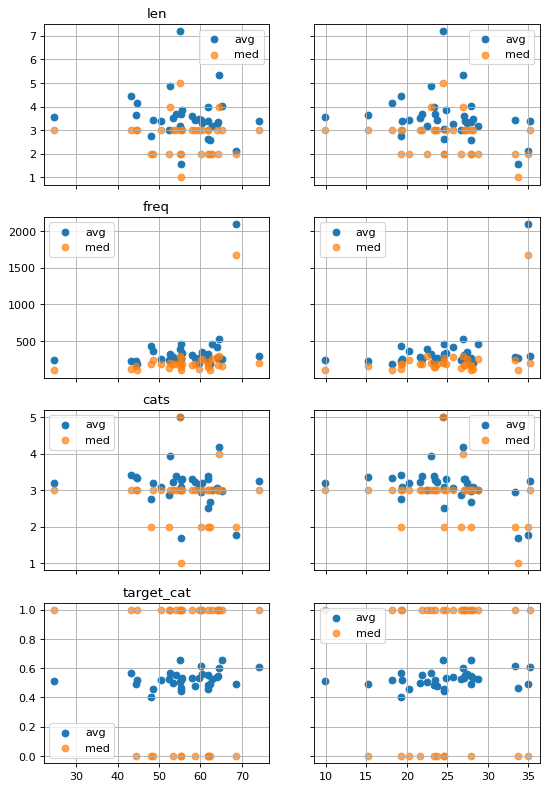

In [39]:
cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(4, 2, sharex='col', sharey='row', figsize=(8, 12), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(gm_df.hit, gm_df[a], label='avg')
    ax[i,0].scatter(gm_df.hit, gm_df[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(gm_df.mrr, gm_df[a], label='avg')
    ax[i,1].scatter(gm_df.mrr, gm_df[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


# analyse item embeddings

In [197]:
items_numbers_df=items_df.drop_duplicates(subset='item_number').reset_index(drop=True)#.loc[items_df.category==cat].index

In [20]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [21]:
items_numbers_df

item_id category  item_number frequency
0      214536502        9        15489       151
1      214536500        9        12173       137
2      214536506        9         3607         2
3      214577561        9         8568        40
4      214662742        3        16321       141
...          ...      ...          ...       ...
27803  214816097       11        14107         3
27804  214863885       12         2367         3
27805  214854665        2        26575         2
27806  214862535       12           10         1
27807  214862891       12         6188         2

[27808 rows x 4 columns]

## input (beore gnn)

## GMM

In [22]:
items_embeddings=get_items_embedding(model, torch.tensor(items_df.item_number.unique())).detach().numpy()
gm=GaussianMixture(n_components=16, n_init=8)
    
item_labels=gm.fit_predict(items_embeddings)

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 8 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [23]:
tsne=TSNE(2)
tsne_items_embeddings=tsne.fit_transform(items_embeddings)

In [24]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced item embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

### item embedding vs frequency

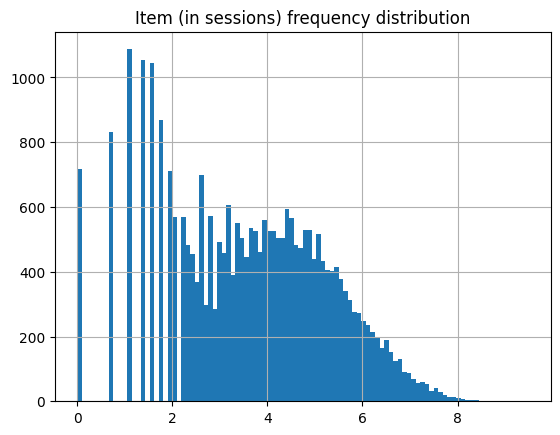

In [40]:
plt.hist(np.log(np.asarray(items_numbers_df.frequency.values, dtype=float)), bins=100)
plt.grid()
plt.title('Item (in sessions) frequency distribution')
plt.show()

In [29]:
tsne=TSNE(1)
tsne1d_items_embeddings=tsne.fit_transform(items_embeddings).flatten()

In [43]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne1d_items_embeddings[item_labels==label]
    label_frequencies=items_numbers_df.frequency.values[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding, y=label_frequencies, name=str(label), mode='markers'))

fig.update_layout(title='TSNE item embeddings VS frequency with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

## GNN embeddings

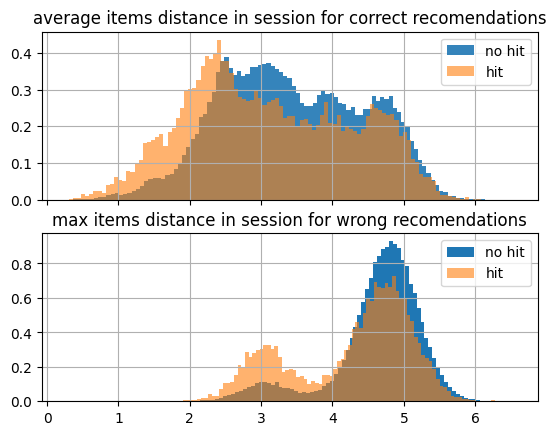

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True)



ax[0].hist(emb_avg_nohit, label='no hit', alpha=0.9, cumulative=False, density=True, bins=100)
ax[0].hist(emb_avg_hit, label='hit', alpha=0.6, cumulative=False, density=True, bins=100)
ax[0].set_title('average items distance in session for correct recomendations')
ax[0].grid()
ax[0].legend()

ax[1].hist(emb_max_nohit, label='no hit', cumulative=False, density=True, bins=100)
ax[1].hist(emb_max_hit, label='hit', cumulative=False, density=True, bins=100, alpha=0.6)
ax[1].set_title('max items distance in session for wrong recomendations')
ax[1].grid()
ax[1].legend()

plt.show()

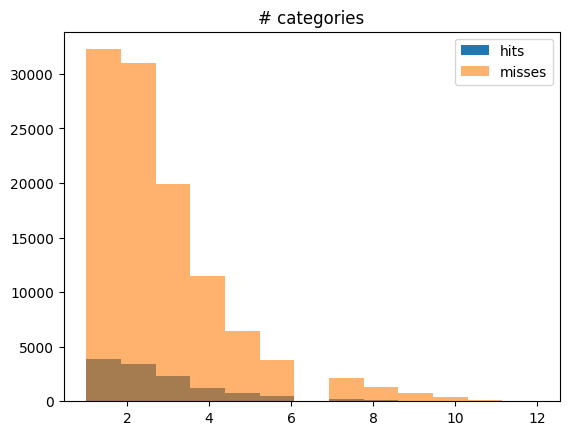

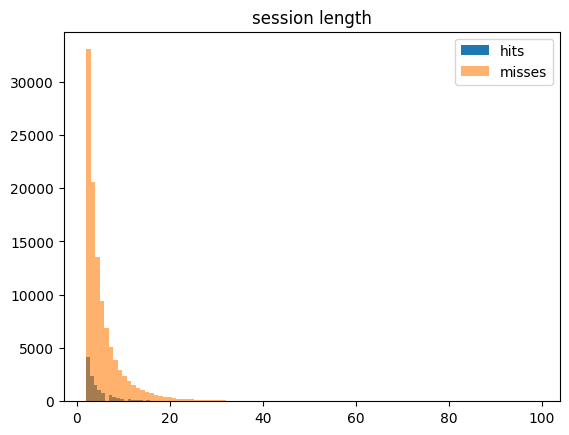

In [29]:
session_stats=np.asarray(session_stats)
hits=session_stats[:,2]==1
plt.hist(session_stats[hits, 0], label='hits', bins=13)
plt.hist(session_stats[~hits, 0], label='misses', alpha=0.6, bins=13)
plt.title('# categories')
plt.legend()
plt.show()

plt.hist(session_stats[hits, 1], label='hits', bins=100)
plt.hist(session_stats[~hits, 1], label='misses', alpha=0.6, bins=100)
plt.title('session length')
plt.legend()
plt.show()